In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
drive_path = r"E:\Hakaton\participants\participants\data"
authors = pd.read_csv(f"{drive_path}/authors.csv")
book_genres = pd.read_csv(f"{drive_path}/book_genres.csv")
editions = pd.read_csv(f"{drive_path}/editions.csv")
genres = pd.read_csv(f"{drive_path}/genres.csv")
users = pd.read_csv(f"{drive_path}/users.csv")
interactions = pd.read_csv(f"{drive_path}/interactions.csv")

drive_path = r"E:\Hakaton\participants\participants\submit"
targets = pd.read_csv(f"{drive_path}/targets.csv")
candidates = pd.read_csv(f"{drive_path}/candidates.csv")

In [5]:
metadata = pd.merge(interactions, editions, on="edition_id", how="left")
metadata = pd.merge(metadata, book_genres, on="book_id", how="left")
metadata = pd.merge(metadata, genres, on="genre_id", how="left")
metadata = pd.merge(metadata, authors, on="author_id", how="left")
metadata = pd.merge(metadata, users, on="user_id", how="left")

# Размер: 464744 строк, 18 столбцов (в итоге 21 столбец!!!)

In [6]:
# Проверяем сколько негативов event_type 0 нужно генерить
metadata.groupby(["user_id", "event_type"]).size().groupby("event_type").mean().reset_index()
# Вывод: от 47 до 59
# TODO: Для каждого пользователя подбирать его
# TODO: собственное количество негативов

,event_type,0
0,1,47.810119
1,2,59.073307


In [7]:
metadata.isna().sum()

"""
rating - 211108 пропусков, половина датасета, можно дропнуть
description - 7006 пропусков, не критично, можно заполнить значением 'Пустое описание'
author_name - 2336 пропусков, имея author_id не критично
gender - 13889 пропусков, тоже не критично на общем размере 470.000
age - 8012 пропусков, можно заполнить медианой
"""

"\nrating - 211108 пропусков, половина датасета, можно дропнуть\ndescription - 7006 пропусков, не критично, можно заполнить значением 'Пустое описание'\nauthor_name - 2336 пропусков, имея author_id не критично\ngender - 13889 пропусков, тоже не критично на общем размере 470.000\nage - 8012 пропусков, можно заполнить медианой\n"

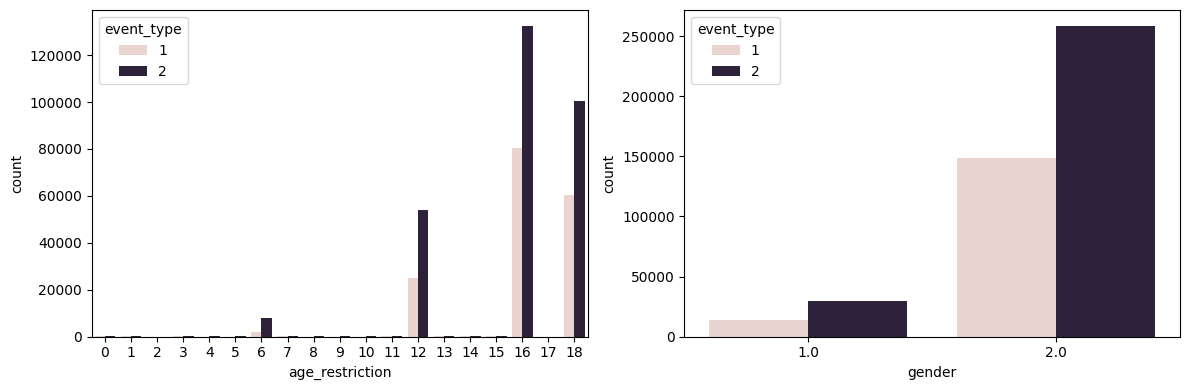

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=metadata, x='age_restriction', hue='event_type', ax=axes[0])
sns.countplot(data=metadata, x='gender', hue='event_type', ax=axes[1])
plt.tight_layout()
plt.show()

In [9]:
"""
Выводы:
    1. 16+ самое распространненое ограничение | Порядок: (16+, 18+, 12+ и 6+)
    2. event_type 2.0 > 1.0
    3. gender 2.0 > gender 1.0
    4. Возрастные категории:
        - 6+ = гораздо больше читают, чем добавляют wishlist
        - 12+ = 30.000 wishlist / 60.000 читают
        - 16+ = 80.000 wishlist / 140.000 читают
        - 18+ = 60.000 wishlist / 100.000 читают

Следовательно:
    - Дисбаланс классов между event_type
    - Женщин (2.0) больше, чем мужчин (1.0)
    - Чем старше - тем больше % wishlist'ов
    - age_restriction - сильная фича
    - Нужен (up/down)sampling для event_type
    - Можно использовать age_restriction при построении эмбединга
"""

"\nВыводы:\n    1. 16+ самое распространненое ограничение | Порядок: (16+, 18+, 12+ и 6+)\n    2. event_type 2.0 > 1.0\n    3. gender 2.0 > gender 1.0\n    4. Возрастные категории:\n        - 6+ = гораздо больше читают, чем добавляют wishlist\n        - 12+ = 30.000 wishlist / 60.000 читают\n        - 16+ = 80.000 wishlist / 140.000 читают\n        - 18+ = 60.000 wishlist / 100.000 читают\n\nСледовательно:\n    - Дисбаланс классов между event_type\n    - Женщин (2.0) больше, чем мужчин (1.0)\n    - Чем старше - тем больше % wishlist'ов\n    - age_restriction - сильная фича\n    - Нужен (up/down)sampling для event_type\n    - Можно использовать age_restriction при построении эмбединга\n"

In [10]:
metadata["timestamp"] = pd.to_datetime(metadata["event_ts"])
metadata.drop(columns=["event_ts"], inplace = True)

In [11]:
metadata["year"] = metadata["timestamp"].dt.year
metadata["month"] = metadata["timestamp"].dt.month
metadata["day"] = metadata["timestamp"].dt.day
metadata["hour"] = metadata["timestamp"].dt.hour
metadata["day_of_week"] = metadata["timestamp"].dt.dayofweek
metadata["is_weekend"] = metadata["day_of_week"].isin([5, 6]).astype(int)

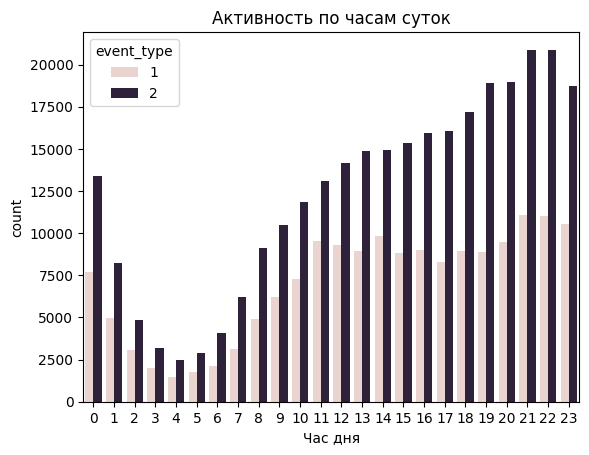

In [12]:
sns.countplot(data=metadata, x='hour', hue='event_type')
plt.title('Активность по часам суток')
plt.xlabel('Час дня')
plt.show()

# Время суток почти не влияет на соотношение wishlist к read

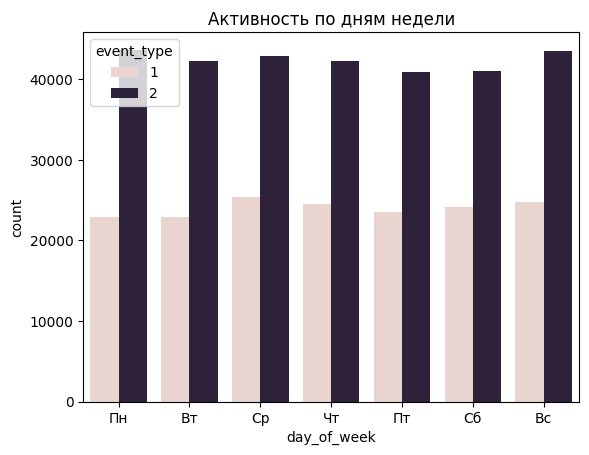

In [13]:
# Активность по дням недели
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
sns.countplot(data=metadata, x='day_of_week', hue='event_type')
plt.xticks(range(7), day_names)
plt.title('Активность по дням недели')
plt.show()

# Вывод: деннь недели почти не влиет на соотношение wishlist к read

In [14]:
metadata.groupby('event_type')['hour'].agg(['mean', 'median', 'std'])

# Часы тоже не играют особой роли, время для обоих групп почти одинаково

,mean,median,std
event_type,,,
1,14.018062,15.0,6.508624
2,14.348375,15.0,6.519910


In [15]:
drop_features = ['hour', 'day_of_week', 'is_weekend', 'month']
metadata.drop(columns=drop_features, inplace=True)

In [16]:
metadata['book_age_years'] = 2025 - metadata['publication_year']

In [17]:
print("Уникальных значений:")
uniques = [f"{col}: {len(metadata[col].unique())}" for col in metadata.columns]
print("\n".join(uniques))

Уникальных значений:
user_id: 5067
edition_id: 74528
event_type: 2
rating: 11
book_id: 59026
author_id: 22186
publication_year: 126
age_restriction: 19
language_id: 26
publisher_id: 3719
title: 59390
description: 69601
genre_id: 500
genre_name: 500
author_name: 21967
gender: 3
age: 75
timestamp: 228212
year: 2
day: 31
book_age_years: 126


In [18]:
print("Взаимодействий в 2025: ", len(metadata[metadata.year == 2025]))
print("Взаимодействий в 2024: ", len(metadata[metadata.year == 2024]))

Взаимодействий в 2025:  283892
Взаимодействий в 2024:  180852


In [19]:
print("Холодный старт:")
cold_users = set(set(targets["user_id"]) - set(metadata["user_id"]))
print("Холодных пользователей: ", len(cold_users))
cold_users = set(set(candidates["edition_id"]) - set(editions["edition_id"]))
print("Холодных изданий: ", len(cold_users))
print("Всего изданий в кандидатах: ", len(candidates["edition_id"].unique()))
print("Всего изданий в датасете: ", len(metadata["edition_id"].unique()))


interacted_editions = set(interactions['edition_id'].unique())
candidates_editions = set(candidates['edition_id'].unique())
cold_editions = candidates_editions - interacted_editions
warm_editions = candidates_editions & interacted_editions
print(f"\nТеплых изданий (есть история): {len(warm_editions)} ({len(warm_editions)/len(candidates_editions)*100:.1f}%)")
print(f"Холодных изданий (нет истории): {len(cold_editions)} ({len(cold_editions)/len(candidates_editions)*100:.1f}%)")

Холодный старт:
Холодных пользователей:  0
Холодных изданий:  0
Всего изданий в кандидатах:  82961
Всего изданий в датасете:  74528

Теплых изданий (есть история): 46684 (56.3%)
Холодных изданий (нет истории): 36277 (43.7%)


In [20]:
metadata.to_csv("metadata.csv")

In [23]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464744 entries, 0 to 464743
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           464744 non-null  int64         
 1   edition_id        464744 non-null  int64         
 2   event_type        464744 non-null  int64         
 3   rating            253636 non-null  float64       
 4   book_id           464744 non-null  int64         
 5   author_id         464744 non-null  float64       
 6   publication_year  464744 non-null  int64         
 7   age_restriction   464744 non-null  int64         
 8   language_id       464744 non-null  int64         
 9   publisher_id      464744 non-null  int64         
 10  title             464744 non-null  object        
 11  description       457738 non-null  object        
 12  genre_id          464744 non-null  int64         
 13  genre_name        464744 non-null  object        
 14  auth

In [22]:
"""
Итог анализа данных:
Холодный старт:
Холодных пользователей:  0
Холодных изданий:  0
Всего изданий в кандидатах:  82961
Всего изданий в датасете:  74528

Теплых изданий (есть история): 46684 (56.3%)
Холодных изданий (нет истории): 36277 (43.7%)

Взаимодействий в 2025:  283892
Взаимодействий в 2024:  180852

Уникальных значений:
user_id: 5067
edition_id: 74528
event_type: 2
rating: 11
book_id: 59026
author_id: 22186
publication_year: 126
age_restriction: 19
language_id: 26
publisher_id: 3719
title: 59390
description: 69601
genre_id: 500
genre_name: 500
author_name: 21967
gender: 3
age: 75
timestamp: 228212
year: 2
day: 31
book_age_years: 126

Вывод: деннь недели почти не влиет на соотношение wishlist к read
Время суток почти не влияет на соотношение wishlist к read
Часы тоже не играют особой роли, время для обоих групп почти одинаково

Выводы по возрасту и полу:
    1. 16+ самое распространненое ограничение | Порядок: (16+, 18+, 12+ и 6+)
    2. event_type 2.0 > 1.0
    3. gender 2.0 > gender 1.0
    4. Возрастные категории:
        - 6+ = гораздо больше читают, чем добавляют wishlist
        - 12+ = 30.000 wishlist / 60.000 читают
        - 16+ = 80.000 wishlist / 140.000 читают
        - 18+ = 60.000 wishlist / 100.000 читают

Следовательно:
    - Дисбаланс классов между event_type
    - Женщин (2.0) больше, чем мужчин (1.0)
    - Чем старше - тем больше % wishlist'ов
    - age_restriction - сильная фича
    - Нужен (up/down)sampling для event_type
    - Можно использовать age_restriction при построении эмбединга

rating - 211108 пропусков, половина датасета, можно дропнуть
description - 7006 пропусков, не критично, можно заполнить значением 'Пустое описание'
author_name - 2336 пропусков, имея author_id не критично
gender - 13889 пропусков, тоже не критично на общем размере 470.000
age - 8012 пропусков, можно заполнить медианой


Общее количество взаимодействий в датасете: 464744
"""

"\nИтог анализа данных:\nХолодный старт:\nХолодных пользователей:  0\nХолодных изданий:  0\nВсего изданий в кандидатах:  82961\nВсего изданий в датасете:  74528\n\nТеплых изданий (есть история): 46684 (56.3%)\nХолодных изданий (нет истории): 36277 (43.7%)\n\nВзаимодействий в 2025:  283892\nВзаимодействий в 2024:  180852\n\nУникальных значений:\nuser_id: 5067\nedition_id: 74528\nevent_type: 2\nrating: 11\nbook_id: 59026\nauthor_id: 22186\npublication_year: 126\nage_restriction: 19\nlanguage_id: 26\npublisher_id: 3719\ntitle: 59390\ndescription: 69601\ngenre_id: 500\ngenre_name: 500\nauthor_name: 21967\ngender: 3\nage: 75\ntimestamp: 228212\nyear: 2\nday: 31\nbook_age_years: 126\n\nВывод: деннь недели почти не влиет на соотношение wishlist к read\nВремя суток почти не влияет на соотношение wishlist к read\nЧасы тоже не играют особой роли, время для обоих групп почти одинаково\n\nВыводы по возрасту и полу:\n    1. 16+ самое распространненое ограничение | Порядок: (16+, 18+, 12+ и 6+)\n   